#  SETUP

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

# DATASET IMPORT

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
! kaggle competitions download -c hotel-id-to-combat-human-trafficking-2022-fgvc9

100% 14.0G/14.0G [10:12<00:00, 25.8MB/s]
100% 14.0G/14.0G [10:12<00:00, 24.6MB/s]


In [ ]:
! unzip /content/hotel-id-to-combat-human-trafficking-2022-fgvc9.zip

#**DATASET FROM DIRECTORY (labels are integer encoded)**

In [ ]:
data_dir = "/content/train_images"
img_height = 64
img_width = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  label_mode = 'int',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=35763)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels = 'inferred',
  label_mode = 'int',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=8940)

Found 44703 files belonging to 3116 classes.
Using 35763 files for training.
Found 44703 files belonging to 3116 classes.
Using 8940 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)
print(len(class_names))

['100055', '10010', '100143', '100206', '100292', '100297', '10031', '100317', '100326', '100410', '10054', '1007', '100784', '100860', '1009', '101242', '10129', '1013', '101396', '101899', '10191', '101974', '102048', '102119', '10214', '102157', '102219', '10283', '10284', '10290', '102917', '102950', '102995', '10300', '103150', '103164', '103254', '103319', '103379', '103458', '103533', '103650', '10389', '10390', '10394', '10410', '10411', '10425', '104342', '104393', '1046', '10475', '10503', '10542', '10578', '1060', '10678', '106794', '10684', '106915', '107043', '107115', '10728', '107503', '10751', '10755', '10766', '10771', '10776', '10785', '10790', '10807', '10824', '10834', '10838', '10849', '10854', '10855', '108817', '10884', '108959', '10907', '109168', '10947', '109481', '10959', '110119', '11025', '11039', '110509', '11060', '11099', '11101', '111413', '111485', '11165', '111671', '11200', '112022', '112194', '1122', '1123', '11254', '11257', '11260', '11279', '1128

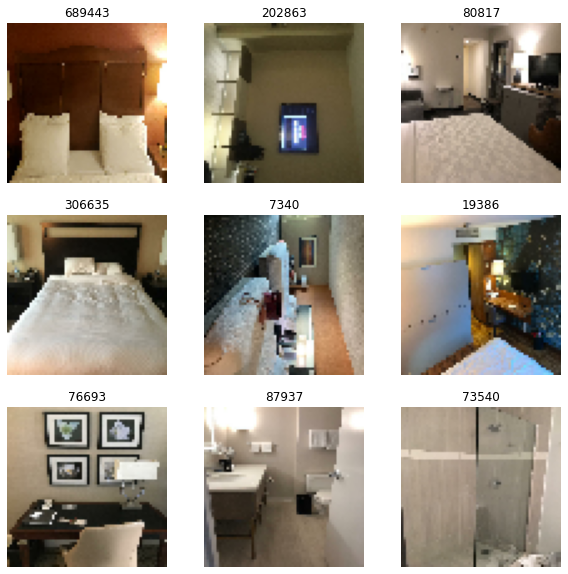

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#**MAKING X TRAIN, Y TRAIN, X VALID, Y VALID (for convenience of training)**

In [ ]:
for image_batch, labels_batch in train_ds:
  X_train = image_batch
  y_train = labels_batch
  break

In [ ]:
for image_batch, labels_batch in val_ds:
  X_valid = image_batch
  y_valid = labels_batch
  break

In [ ]:
X_train = X_train.numpy() #35763,64,64,3
y_train = y_train.numpy() #35763,
X_valid = X_valid.numpy() #8940,64,64,3
y_valid= y_valid.numpy() #8940,64,64,3

TESTING IF THERE ARE NULL VALUES IN TRAINING DATASET (as this will result in nan loss and thus no training)

In [ ]:
print(np.isnan(np.min(X_train)))

False


In [ ]:
print(np.isnan(np.min(y_train)))

False


# DATA CLEANING, PREPROCESSING FOR TRIPLET MODEL 

INVESTIGATING THE CLASSES THAT HAVE LESS THAN 2 PHOTOS IN THEM (deep metric learning cannot be performed for these classes)

In [ ]:
from collections import Counter
 
def toberemovedElements(lst, k):
    counted = Counter(lst)
    return [el for el in lst if counted[el] < k]

In [ ]:
to_be_removed_classes = np.unique(toberemovedElements(y_train,2))

In [ ]:
len(to_be_removed_classes)

28

In [ ]:
reqd = []
for i in range(len(to_be_removed_classes)):
  indices = list(np.where(y_train == to_be_removed_classes[i])[0])
  for j in range(len(indices)):
    reqd.append(indices[j]) 

In [ ]:
indices_to_remove_in_training = list(reqd)
indices_to_remove_in_training.sort(reverse= True) #index numbers in descending order

x train cleaning

In [ ]:
X_triplet_train = list(X_train) #removing the index numbers from X train
for i in range(len(indices_to_remove_in_training)):
  X_triplet_train.pop(indices_to_remove_in_training[i])

In [ ]:
X_triplet_train = np.array(X_triplet_train)
X_triplet_train.shape

(35735, 64, 64, 3)

y train cleaning

In [ ]:
y_triplet_train = list(y_train) #removing the index numbers from y train
for i in range(len(indices_to_remove_in_training)):
  y_triplet_train.pop(indices_to_remove_in_training[i])

In [ ]:
y_triplet_train = np.array(y_triplet_train)
y_triplet_train.shape

(35735,)

In [ ]:
classes = np.unique(y_triplet_train)
classes = list(classes)
len(classes) #check if it matches initial classes - removed number of classes

3084

In [ ]:
#scaling
X_triplet_train = X_triplet_train.astype("float32")/255.

#DATA GENERATOR FOR THE TRIPLET MODEL

In [ ]:
def data_generator(batch_size = 64):
  while True:
    a=[]
    p=[]
    n=[]
    for _ in range(batch_size):
      pos_neg = random.sample(classes,2)
      positive_samples = np.array(random.sample(list(X_triplet_train[y_triplet_train == pos_neg[0]]), 2)) #2,64,64,3
      negative_samples= np.array(random.sample(list(X_triplet_train[y_triplet_train == pos_neg[1]]),1)) #1,64,64,3
      a.append(positive_samples[0]) #finally 64,64,64,3
      p.append(positive_samples[1]) #finally 64,64,64,3
      n.append(negative_samples[0]) #finally 64,64,64,3
    yield ( [np.array(a), np.array(p), np.array(n)] , np.zeros((batch_size,1)).astype("float32") )

#TRIPLET LOSS

In [ ]:
def triplet_loss(y_true, y_pred):
  anchor_out = y_pred[:,0:256]
  positive_out = y_pred[:,256:512]
  negative_out = y_pred[:,512:768]
  pos_dist = K.sum(K.abs(anchor_out - positive_out), axis =1) #l1 distance between anchor and positive image
  neg_dist = K.sum(K.abs(anchor_out - negative_out), axis =1) #l2 distance between anchor and negative image 
  #IBM research function
  probs = K.softmax([pos_dist, neg_dist], axis =0)
  return K.mean(K.abs(probs[0]) + K.abs(1.-probs[1]))

#vgg19 - feature extraction (256 dimension vector)

In [ ]:
model = tf.keras.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape= (64,64,3)
)

80134624/80134624 [==============================] - 3s 0us/step


In [ ]:
model.trainable = False

In [ ]:
base_model = keras.Sequential(
       [ model, 
       keras.layers.Flatten(),
       keras.layers.Dense(256, activation = 'relu')]
)

In [ ]:
base_model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
Total params: 20,548,928
Trainable params: 524,544
Non-trainable params: 20,024,384
_________________________________________________________________


#TRIPLET MODEL 

In [ ]:
triplet_model_a = tf.keras.Input((64,64,3))
triplet_model_p = tf.keras.Input((64,64,3))
triplet_model_n = tf.keras.Input((64,64,3))
triplet_model_out = keras.layers.concatenate([base_model(triplet_model_a),base_model(triplet_model_p), base_model(triplet_model_n)]) #None,768
triplet_model = Model([triplet_model_a,triplet_model_p,triplet_model_n], triplet_model_out) #model inputs, output

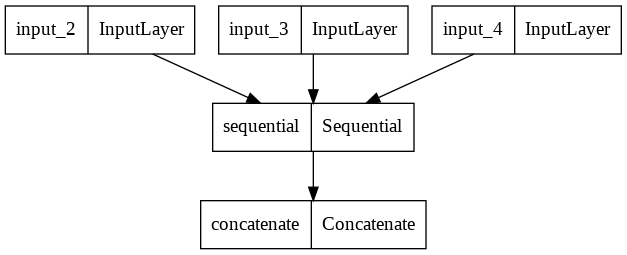

In [ ]:
tf.keras.utils.plot_model(
    triplet_model)

#TRAINING OF TRIPLET MODEL

In [ ]:
triplet_model.compile(loss = triplet_loss, optimizer = 'adam')

In [ ]:
triplet_model.fit(data_generator(), steps_per_epoch = 150, epochs=5)

Epoch 1/5
150/150 [==============================] - 24s 92ms/step - loss: 0.8602
Epoch 2/5
150/150 [==============================] - 14s 92ms/step - loss: 0.8556
Epoch 3/5
150/150 [==============================] - 14s 93ms/step - loss: 0.8409
Epoch 4/5
150/150 [==============================] - 14s 94ms/step - loss: 0.8398
Epoch 5/5
150/150 [==============================] - 14s 94ms/step - loss: 0.8305


In [ ]:
triplet_model.trainable = False

#REPLACING LAST LAYER WITH SOFTMAX

In [ ]:
classifier_model = Sequential()
for layer in triplet_model.layers[2:-1]: # go through until last layer
    classifier_model.add(layer)
classifier_model.add(keras.layers.Dense(3116, activation='softmax'))

In [ ]:
classifier_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256)               20548928  
                                                                 
 dense_1 (Dense)             (None, 3116)              800812    
                                                                 
Total params: 21,349,740
Trainable params: 800,812
Non-trainable params: 20,548,928
_________________________________________________________________


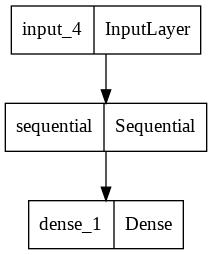

In [ ]:
tf.keras.utils.plot_model(
    classifier_model)

In [ ]:
classifier_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = classifier_model.fit(
  X_train, y_train, validation_data= (X_valid, y_valid),
  epochs=10)

Epoch 1/10
1118/1118 [==============================] - ETA: 0s - loss: 7.5235 - accuracy: 0.4429

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1118/1118 [==============================] - 29s 26ms/step - loss: 7.5235 - accuracy: 0.4429 - val_loss: 51.4033 - val_accuracy: 0.0696
Epoch 2/10
1118/1118 [==============================] - 28s 25ms/step - loss: 7.6139 - accuracy: 0.4441 - val_loss: 52.2902 - val_accuracy: 0.0716
Epoch 3/10
1118/1118 [==============================] - 28s 25ms/step - loss: 7.3371 - accuracy: 0.4595 - val_loss: 53.0605 - val_accuracy: 0.0711
Epoch 4/10
1118/1118 [==============================] - 28s 25ms/step - loss: 7.0751 - accuracy: 0.4718 - val_loss: 54.0231 - val_accuracy: 0.0809
Epoch 5/10
1118/1118 [==============================] - 28s 25ms/step - loss: 6.9316 - accuracy: 0.4803 - val_loss: 55.2952 - val_accuracy: 0.0784
Epoch 6/10
1118/1118 [==============================] - 28s 25ms/step - loss: 6.9093 - accuracy: 0.4827 - val_loss: 55.3625 - val_accuracy: 0.0770
Epoch 7/10
1118/1118 [==============================] - 28s 25ms/step - loss: 6.6520 - accuracy: 0.4990 - val_loss: 56.7933 - val

#VISUALISING TRAINING AND VALIDATION DATA RESULTS

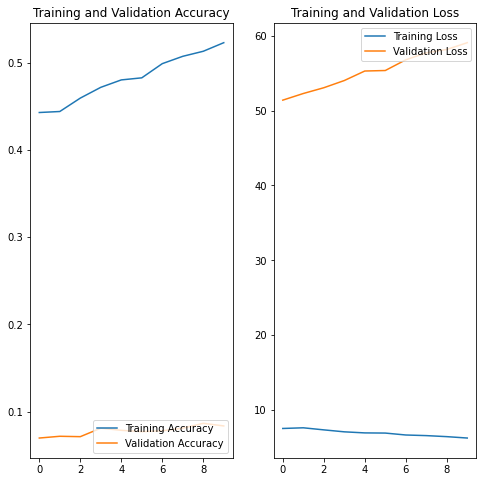

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can see clear overfitting problem here 

# DATA AUGMENTATION

In [ ]:
data_augmentation = keras.Sequential(
  [
    keras.layers.RandomFlip("horizontal",
                      input_shape=(64,64,3)),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1)
  ])

In [ ]:
better= Sequential([
  data_augmentation])

In [ ]:
for layer in classifier_model.layers[:]: 
    better.add(layer)

In [ ]:
better.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = better.fit(
  X_train, y_train, validation_data= (X_valid, y_valid),
  epochs=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1118/1118 [==============================] - 47s 41ms/step - loss: 43.6405 - accuracy: 0.0552 - val_loss: 60.6855 - val_accuracy: 0.0700
Epoch 2/10
1118/1118 [==============================] - 43s 38ms/step - loss: 39.4591 - accuracy: 0.0627 - val_loss: 59.9186 - val_accuracy: 0.0633
Epoch 3/10
1118/1118 [==============================] - 43s 38ms/step - loss: 36.7411 - accuracy: 0.0638 - val_loss: 59.2616 - val_accuracy: 0.0601
Epoch 4/10
1118/1118 [==============================] - 42s 38ms/step - loss: 34.9792 - accuracy: 0.0695 - val_loss: 58.8170 - val_accuracy: 0.0534
Epoch 5/10
1118/1118 [==============================] - 43s 38ms/step - loss: 33.5869 - accuracy: 0.0741 - val_loss: 57.7199 - val_accuracy: 0.0537
Epoch 6/10
1118/1118 [==============================] - 43s 38ms/step - loss: 32.1345 - accuracy: 0.0768 - val_loss: 58.2093 - val_accuracy: 0.0485
Epoch 7/10
1118/1118 [==============================] - 43s 38ms/step - loss: 31.1131 - accuracy: 0.0779 - val_loss: 57.420

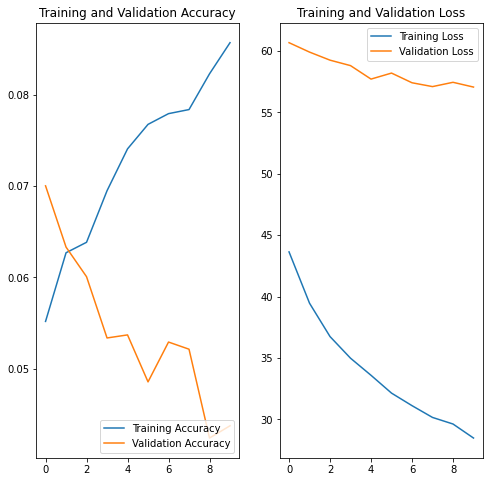

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Improvements or inferences



*   softmax is not a great activation function for more than 3000 classes - can use softmax temperature activation function 
*   pretrain on hotel50k dataset or facial recognition dataset like arcnet (not enough gpu support rn) for better results








